# Glaucoma Segmentation


## Imports

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from networks import *
from training import *
from utils import *

## Setup

In [2]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
LOGS_DIR = '../logs/'
CHECKPOINT_DIR = '../checkpoints/'
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
IN_CHANNELS = 3
OUT_CHANNELS = 3
NETWORK_NAME = 'unet'
LOSS_FUNCTION = 'dice'
OPTIMIZER = 'adam'
ARCHITECTURE = 'multilabel'  # multiclass, multilabel, binary, dual, cascade
BINARY_TARGET_CLASSES = [1, 2]
SCHEDULER = 'plateau'
SCALER = 'none'
DATASET = 'ORIGA'
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
LAYERS = [32, 64, 128, 256, 512]
EARLY_STOPPING_PATIENCE = 10
LOG_INTERVAL = 5
SAVE_INTERVAL = 10
NUM_WORKERS = 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEMORY = True if DEVICE == 'cuda' else False
USE_WANDB = False
DEEP_SUPERVISION = False

os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f'''CONFIGURATION:
    PyTorch version: {torch.__version__}
    Using device: {DEVICE}
    Network: {NETWORK_NAME}
    Architecture: {ARCHITECTURE}
    Optimizer: {OPTIMIZER}
    Loss function: {LOSS_FUNCTION}
    Scheduler: {SCHEDULER}
    Scaler: {SCALER}
    Dataset: {DATASET}
    Image directory: {IMAGE_DIR}
    Mask directory: {MASK_DIR}
    Input image height & width: {IMAGE_HEIGHT}x{IMAGE_WIDTH}
    Number of input channels: {IN_CHANNELS}
    Number of output channels: {OUT_CHANNELS}
    Layers: {LAYERS}
    Batch size: {BATCH_SIZE}
    Learning rate: {LEARNING_RATE}
    Epochs: {EPOCHS}
    Early stopping patience: {EARLY_STOPPING_PATIENCE}
    Save interval: {SAVE_INTERVAL}
    Log interval: {LOG_INTERVAL}
    Number of workers: {NUM_WORKERS}
    Pin memory: {PIN_MEMORY}
    Weight & Biases: {USE_WANDB}
    Deep supervision: {DEEP_SUPERVISION}''')

CONFIGURATION:
    PyTorch version: 2.0.1+cu118
    Using device: cuda
    Network: unet
    Architecture: multilabel
    Optimizer: adam
    Loss function: dice
    Scheduler: plateau
    Scaler: none
    Dataset: ORIGA
    Image directory: ../data/ORIGA/Images_Cropped
    Mask directory: ../data/ORIGA/Masks_Cropped
    Input image height & width: 128x128
    Number of input channels: 3
    Number of output channels: 3
    Layers: [32, 64, 128, 256, 512]
    Batch size: 4
    Learning rate: 0.0001
    Epochs: 5
    Early stopping patience: 10
    Save interval: 10
    Log interval: 5
    Number of workers: 0
    Pin memory: False
    Weight & Biases: False
    Deep supervision: False


## Dataset

Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5922, 1: 5486, 2: 4976}


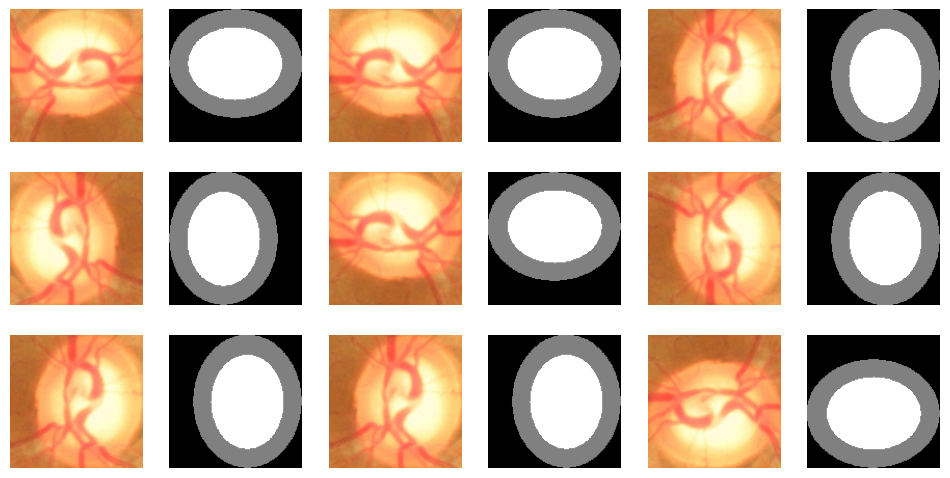

In [3]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    # A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    # A.Lambda(image=occlude),
    # A.Lambda(image=polar_transform, mask=polar_transform),
    # A.Lambda(image=inverse_polar_transform, mask=inverse_polar_transform),
    # A.Sharpen(p=0.5, alpha=(0.1, 0.3), lightness=(0.5, 1.0)),

    # A.CLAHE(p=0.5),
    # A.RandomBrightnessContrast(p=0.5),
    # A.GridDistortion(p=0.5, border_mode=cv.BORDER_CONSTANT),
    # A.MedianBlur(p=0.5),
    # A.RandomToneCurve(p=0.5),
    # A.MultiplicativeNoise(p=0.5),

    # A.Lambda(image=keep_gray_channel),
    # A.Lambda(image=keep_red_channel),
    # A.Lambda(image=keep_green_channel),
    # A.Lambda(image=keep_blue_channel),

    ToTensorV2(),
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    batch = next(iter(example_loader))
    images, masks = batch
    image, mask = images[0], masks[0]
    image = image.permute(1, 2, 0).numpy()
    mask = mask.numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [4]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    # A.Lambda(image=occlude),
    # A.Lambda(image=polar_transform, mask=polar_transform),
    # A.Lambda(image=keep_gray_channel),
    # A.Lambda(image=keep_red_channel),
    # A.Lambda(image=keep_green_channel),
    # A.Lambda(image=keep_blue_channel),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    # A.Lambda(image=polar_transform, mask=polar_transform),
    # A.Lambda(image=keep_gray_channel),
    # A.Lambda(image=keep_red_channel),
    # A.Lambda(image=keep_green_channel),
    # A.Lambda(image=keep_blue_channel),
    ToTensorV2(),
])

train_loader, val_loader, test_loader = load_origa(
    IMAGE_DIR, MASK_DIR, 0.7, 0.15, 0.15,
    train_transform, val_transform, val_transform, BATCH_SIZE, PIN_MEMORY, NUM_WORKERS,
)


Loading ORIGA dataset:
    Train size: 454 (69.85%)
    Validation size: 98 (15.08%)
    Test size: 98 (15.08%)
    
    Image shape: (3, 128, 128)
    Mask shape: (128, 128)
    Batch size: 4

    Train loader length: 114
    Validation loader length: 25
    Test loader length: 25


## Model

In [5]:
model = get_network(NETWORK_NAME, in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, layers=LAYERS).to(DEVICE)
optimizer = get_optimizer(OPTIMIZER, model.parameters(), lr=LEARNING_RATE)
criterion = get_criterion(LOSS_FUNCTION, num_classes=OUT_CHANNELS if ARCHITECTURE == 'multiclass' else 1)
scheduler = get_scheduler(SCHEDULER, optimizer, factor=0.1, patience=5, verbose=True)
scaler = get_scaler(SCALER)

init_weights(model)

Initialized Unet network parameters with kaiming method.


In [6]:
# WEIGHT_DECAY = 1e-4
# 
# config = Config()
# model = SwinUnet(config, img_size=224, num_classes=OUT_CHANNELS, zero_head=False, vis=False).to(DEVICE)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=True)

In [7]:
# hist = train_multiclass(
#     model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler,
#     save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
#     log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
#     save_best_model=True, plot_examples='all', show_plots=True,
# )
# plot_history(hist)

## Training

In [ ]:
if ARCHITECTURE == 'multiclass':
    hist = train_multiclass(
        model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
    )

if ARCHITECTURE == 'multilabel':
    hist = train_multilabel(
        model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
    )

if ARCHITECTURE == 'binary':
    hist = train_binary(
        model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False, target_ids=BINARY_TARGET_CLASSES,
    )

if ARCHITECTURE == 'dual':
    hist = train_dual(
        model, criterion, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
    )

if ARCHITECTURE == 'cascade':
    binary_model = Unet(3, 1, LAYERS).to(DEVICE)
    checkpoint = torch.load(CHECKPOINT_DIR + 'binary-model.pth')
    binary_model.load_state_dict(checkpoint)
    hist = train_cascade(
        binary_model, model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
    )

plot_history(hist)

## Testing

In [ ]:
if ARCHITECTURE == 'multiclass':
    results = evaluate('multiclass', model, test_loader, criterion, DEVICE)

if ARCHITECTURE == 'multilabel':
    results = evaluate('multilabel', model, test_loader, criterion, DEVICE)

if ARCHITECTURE == 'binary':
    results = evaluate('binary', model, test_loader, criterion, DEVICE, class_ids=BINARY_TARGET_CLASSES)

if ARCHITECTURE == 'dual':
    results = evaluate('dual', model, test_loader, criterion, DEVICE)

if ARCHITECTURE == 'cascade':
    binary_model = Unet(3, 1, LAYERS).to(DEVICE)
    checkpoint = torch.load(CHECKPOINT_DIR + 'binary-model.pth')
    binary_model.load_state_dict(checkpoint)
    results = evaluate('cascade', model, test_loader, criterion, DEVICE, model0=binary_model)

In [ ]:
if ARCHITECTURE == 'multiclass':
    plot_results_from_loader('multiclass', test_loader, model, DEVICE, n_samples=4,
                             save_path=f'{LOGS_DIR}/evaluation.png')

if ARCHITECTURE == 'multilabel':
    plot_results_from_loader('multilabel', test_loader, model, DEVICE, n_samples=4,
                             save_path=f'{LOGS_DIR}/evaluation.png')

if ARCHITECTURE == 'binary':
    plot_results_from_loader('binary', test_loader, model, DEVICE, n_samples=4,
                             save_path=f'{LOGS_DIR}/evaluation.png', class_ids=BINARY_TARGET_CLASSES)

if ARCHITECTURE == 'dual':
    plot_results_from_loader('dual', test_loader, model, DEVICE,
                             n_samples=4, save_path=f'{LOGS_DIR}/evaluation.png')

if ARCHITECTURE == 'cascade':
    plot_results_from_loader('cascade', test_loader, model, DEVICE, n_samples=4,
                             save_path=f'{LOGS_DIR}/evaluation.png', model0=binary_model)

## Apply CRF post-processing

image.shape = (128, 128, 3)
mask.shape = (128, 128)
pred.shape = (128, 128)
prob.shape = (3, 128, 128)
Before CRF: 0.8591805545447929 0.9585474477560808
After CRF: 0.861034231609614 0.9563888063187397
Improvement: 0.001853677064821091 -0.0021586414373411245


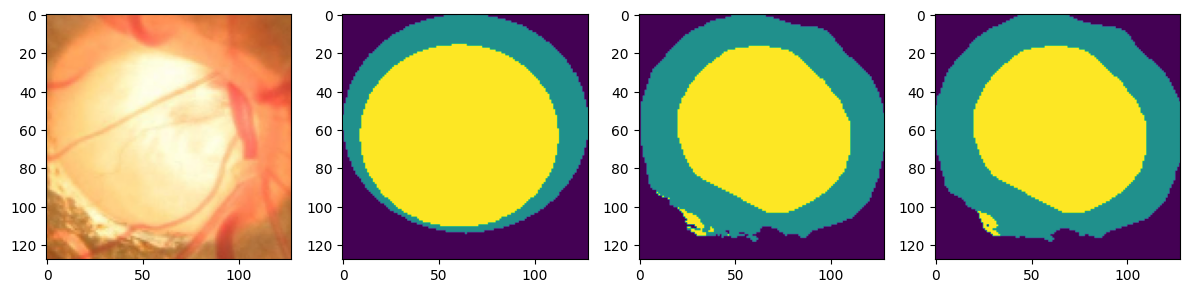

In [110]:
images, masks = next(iter(test_loader))
images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)

outputs = model(images)
probs = torch.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)

images = images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255
masks = masks.detach().cpu().numpy()
preds = preds.detach().cpu().numpy()
probs = probs.detach().cpu().numpy()

idx = 0
image, mask, pred, prob = images[idx], masks[idx], preds[idx], probs[idx]

print(f'{image.shape = }')
print(f'{mask.shape = }')
print(f'{pred.shape = }')
print(f'{prob.shape = }')

pred_crf = dense_crf(image, prob)

m1 = get_metrics(mask, pred, [[1, 2], [2]])
m2 = get_metrics(mask, pred_crf, [[1, 2], [2]])

print('Before CRF:', m1['dice_OC'], m1['dice_OD'])
print('After CRF:', m2['dice_OC'], m2['dice_OD'])
print('Improvement:', m2['dice_OC'] - m1['dice_OC'], m2['dice_OD'] - m1['dice_OD'])

_, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(pred)
ax[3].imshow(pred_crf)
plt.tight_layout()
plt.show()

In [119]:
model = Unet(3, 3, LAYERS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = DiceLoss(1)

trainer = MultilabelTrainer(model, criterion, optimizer, DEVICE)

trainer.train_one_epoch(train_loader)

Training: 100%|██████████| 114/114 [00:09<00:00, 11.57it/s, accuracy_OC=0.832, accuracy_OD=0.812, balance_accuracy_OC=0.863, balance_accuracy_OD=0.847, dice_OC=0.747, dice_OD=0.851, iou_OC=0.608, iou_OD=0.745, learning_rate=0.0001, loss=0.788, precision_OC=0.647, precision_OD=0.965, sensitivity_OC=0.92, sensitivity_OD=0.764, specificity_OC=0.806, specificity_OD=0.931] 


{'accuracy_OD': 0.8115258467824835,
 'precision_OD': 0.9654107934130362,
 'sensitivity_OD': 0.7637700684657602,
 'specificity_OD': 0.9305662876038706,
 'dice_OD': 0.851209287456901,
 'iou_OD': 0.7446352853135106,
 'balance_accuracy_OD': 0.8471681780348156,
 'accuracy_OC': 0.8317944710714775,
 'precision_OC': 0.6465297298867818,
 'sensitivity_OC': 0.9203894572781501,
 'specificity_OC': 0.8063974016607491,
 'dice_OC': 0.7468305783198891,
 'iou_OC': 0.6078859689295026,
 'balance_accuracy_OC': 0.8633934294694497,
 'loss': 0.7879839644097445}

## Work in progress

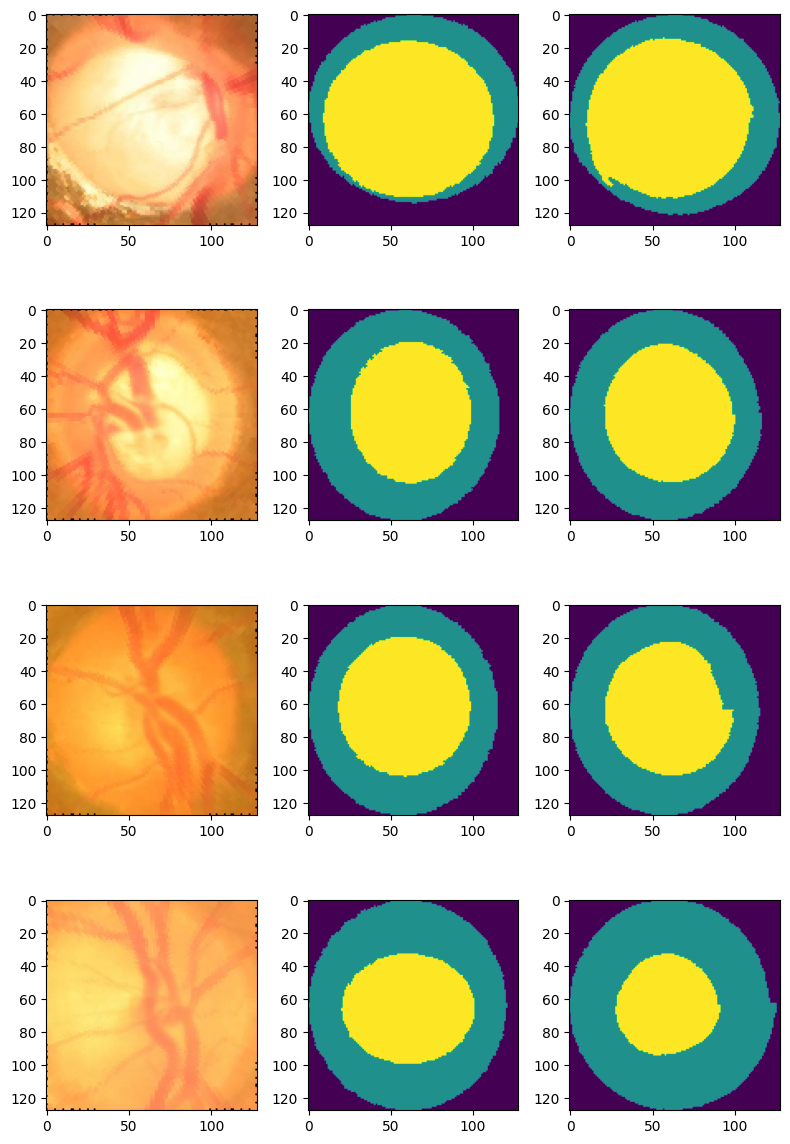

{'accuracy_OD': (0.9865264892578125, 0.9734649658203125),
 'precision_OD': (0.9839813861917759, 0.9706815745780879),
 'sensitivity_OD': (0.9962173548664749, 0.9926069202664948),
 'specificity_OD': (0.9665217188011409, 0.9266021256445333),
 'dice_OD': (0.9900615665132193, 0.9815218199785359),
 'iou_OD': (0.9803187339797169, 0.9637141366718831),
 'accuracy_OC': (0.9658355712890625, 0.955047607421875),
 'precision_OC': (0.9862342590995342, 0.9721667072873508),
 'sensitivity_OC': (0.9395254059028463, 0.8935884224203593),
 'specificity_OC': (0.9886357163201367, 0.9867876067288336),
 'dice_OC': (0.9623133763107842, 0.9312228603445861),
 'iou_OC': (0.9273641524736416, 0.87129750982962)}

In [15]:
images, masks = next(iter(test_loader))
images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)

outputs = model(images)
probs = torch.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)

met1 = get_metrics(masks, preds, [[1, 2], [2]])

images, masks, preds = undo_polar_transform(images, masks, preds)

met2 = get_metrics(masks, preds, [[1, 2], [2]])

images = images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255
masks = masks.detach().cpu().numpy()
preds = preds.detach().cpu().numpy()

fig, ax = plt.subplots(4, 3, figsize=(8, 12))
ax = ax.ravel()
for i in range(4):
    ax[3 * i].imshow(images[i])
    ax[3 * i + 1].imshow(masks[i])
    ax[3 * i + 2].imshow(preds[i])
plt.tight_layout()
plt.show()

{k: (met1[k], met2[k]) for k in met1.keys()}

In [ ]:
# torch.save(model.state_dict(), CHECKPOINT_DIR + 'model.pth')

checkpoint = torch.load(CHECKPOINT_DIR + 'multiclass-unet-model.pth')
model = Unet(3, 3, LAYERS).to(DEVICE)
# model = DualUnet(3, 1, LAYERS).to(DEVICE)
criterion = DiceLoss(3)
model.load_state_dict(checkpoint)

# binary_model = Unet(3, 1, LAYERS).to(DEVICE)
# checkpoint = torch.load(CHECKPOINT_DIR + 'binary-model.pth')
# binary_model.load_state_dict(checkpoint)

In [ ]:
# Non-ellipse: 5, 12
# Holes: 0, 20

target_batch = 12

for batch_idx, (images, masks) in enumerate(test_loader):
    if batch_idx != target_batch:
        continue
    images = images.float().to(DEVICE)
    masks = masks.long().to(DEVICE)

    outputs = model(images)
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

    met = get_metrics(masks, preds, [[1, 2], [2]])

    images = images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255
    masks = masks.detach().cpu().numpy()
    preds = preds.detach().cpu().numpy()

    print(f'Batch {batch_idx} metrics: {met}')

    # Plot results
    fig, ax = plt.subplots(4, 3, figsize=(8, 12))
    ax = ax.ravel()
    for i in range(4):
        ax[3 * i].imshow(images[i])
        ax[3 * i + 1].imshow(masks[i])
        ax[3 * i + 2].imshow(preds[i])
    plt.tight_layout()
    plt.show()

    break

In [ ]:
idx = 1

image = images[idx]
mask = masks[idx]
pred = preds[idx]

mask_od, mask_oc = separate_disc_and_cup_mask(mask)
pred_od, pred_oc = separate_disc_and_cup_mask(pred)

# plot image, OD mask and OC mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.ravel()
ax[0].imshow(image)
ax[1].imshow(pred_od)
ax[2].imshow(pred_oc)
plt.tight_layout()
plt.show()

get_metrics(mask_oc, pred_oc, [[1, 2]])

In [ ]:
mask1 = apply_largest_component_selection(pred)
mask2 = apply_hole_filling(pred)
mask3 = apply_largest_component_selection(apply_hole_filling(pred))
mask4 = apply_hole_filling(apply_largest_component_selection(pred))
mask5 = apply_ellipse_fitting(pred)

# Plot results
_, ax = plt.subplots(2, 4, figsize=(12, 7))
ax = ax.ravel()
for a in ax:
    a.axis('off')

ax[0].set_title('Image')
ax[0].imshow(image)
ax[1].set_title('Ground truth')
ax[1].imshow(mask)
ax[2].set_title('Prediction')
ax[2].imshow(pred)
ax[3].set_title('Largest component')
ax[3].imshow(mask1)
ax[4].set_title('Hole filling')
ax[4].imshow(mask2)
ax[5].set_title('Largest + hole')
ax[5].imshow(mask3)
ax[6].set_title('Hole + largest')
ax[6].imshow(mask4)
ax[7].set_title('Ellipse fitting')
ax[7].imshow(mask5)

plt.tight_layout()
plt.show()

In [ ]:
smoothed_od_mask = smooth_contours(pred_od)
smoothed_oc_mask = smooth_contours(pred_oc)
smoothed_mask = smoothed_od_mask + smoothed_oc_mask

# Plot results
_, ax = plt.subplots(1, 4, figsize=(12, 5))
ax[0].imshow(image)
ax[1].imshow(pred)
ax[2].imshow(smoothed_od_mask)
ax[3].imshow(smoothed_oc_mask)
plt.tight_layout()
plt.show()


def on_trackbar(s):
    s = s / 10
    smoothed_mask = smooth_contours(pred_oc, s)

    m = get_metrics(mask_oc, smoothed_mask, [[1, 2]])
    print(m['dice_OD'])

    # Display the original and smoothed masks side by side
    side_by_side = np.hstack((mask_oc * 255, pred_oc * 255, smoothed_mask * 255))
    cv.imshow('Contour Smoothing', side_by_side)


cv.namedWindow('Contour Smoothing')
cv.createTrackbar('S Parameter', 'Contour Smoothing', 5, 100, on_trackbar)
initial_s = 1.0
on_trackbar(initial_s)

cv.waitKey(0)
cv.destroyAllWindows()

In [ ]:
snake_img = snakes(pred_oc)

# Plot results
fig, ax = plt.subplots(1, 4, figsize=(12, 5))
ax[0].imshow(image)
ax[1].imshow(mask_oc)
ax[2].imshow(pred_oc)
ax[3].imshow(snake_img)
plt.tight_layout()
plt.show()


def on_trackbar(a, b, c):
    a = a / 10
    b = b / 10
    c = c / 10

    snake_mask = snakes(pred_oc, a, b, c)

    m = get_metrics(mask_oc, snake_mask, [[1, 2]])
    print(m['dice_OD'])

    # Display the original and smoothed masks side by side
    side_by_side = np.hstack((mask_oc * 255, pred_oc * 255, snake_mask * 255))
    cv.imshow('Snake', side_by_side)


def on_trackbar1(a):
    global initial_alpha
    initial_alpha = a
    on_trackbar(initial_alpha, initial_beta, initial_gamma)


def on_trackbar2(b):
    global initial_beta
    initial_beta = b
    on_trackbar(initial_alpha, initial_beta, initial_gamma)


def on_trackbar3(c):
    global initial_gamma
    initial_gamma = c
    on_trackbar(initial_alpha, initial_beta, initial_gamma)


initial_alpha = 0.1
initial_beta = 2.0
initial_gamma = 5.0

cv.namedWindow('Snake')
cv.createTrackbar('alpha', 'Snake', 1, 50, on_trackbar1)
cv.createTrackbar('beta', 'Snake', 20, 50, on_trackbar2)
cv.createTrackbar('gamma', 'Snake', 50, 100, on_trackbar3)
on_trackbar(initial_alpha, initial_beta, initial_gamma)

cv.waitKey(0)
cv.destroyAllWindows()

## Contour detection method

In [ ]:
from skimage import segmentation
from scipy.ndimage import distance_transform_edt

images, masks = next(iter(val_loader))
images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)

image = images[0].cpu().numpy().transpose(1, 2, 0) / 255.0
mask = masks[0].cpu().numpy()
prediction = np.zeros_like(mask)
prediction[16:112, 16:112] = 1
prediction[32:96, 32:96] = 2

boundaries = segmentation.find_boundaries(mask, mode='inner').astype(np.uint8)
marked = image.copy()
marked[boundaries == 1] = [0, 0, 0]
dist_map = distance_transform_edt(1 - boundaries)
dist_map = dist_map / dist_map.max()

_, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0, 0].imshow(mask)
ax[0, 1].imshow(boundaries)
ax[0, 2].imshow(dist_map)
ax[0, 3].imshow(dist_map.max() - dist_map)
ax[1, 0].imshow(prediction)
ax[1, 1].imshow(marked)
plt.show()

In [ ]:
model = Unet(in_channels=3, out_channels=1).to(DEVICE)
loss = DiceLoss(num_classes=1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(5):
    acc_loss = 0
    for images, masks in val_loader:

        edge_masks = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2]))
        for b in range(masks.shape[0]):
            mask = masks[b].cpu().numpy()
            boundaries = segmentation.find_boundaries(mask, mode='thick').astype(np.uint8)
            edge_masks[b] = boundaries
        masks = torch.from_numpy(edge_masks)

        images = images.float().to(DEVICE)
        masks = masks.long().to(DEVICE)

        outputs = model(images)
        loss_value = loss(outputs, masks)
        acc_loss += loss_value.item()

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

    # plot example
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    # probs = F.softmax(outputs, dim=1)
    # preds = torch.argmax(probs, dim=1).cpu().numpy()
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float().cpu().numpy().transpose(0, 2, 3, 1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(images[0].transpose(1, 2, 0) / 255.0)
    ax[1].imshow(masks[0])
    ax[2].imshow(preds[0])
    plt.show()

    print(f'Epoch {epoch + 1} loss:', acc_loss / len(val_loader))


## Interpretability

In [65]:
model = Unet(in_channels=3, out_channels=3, features=[32, 64, 128, 256, 512]).to(DEVICE)
checkpoint = torch.load(CHECKPOINT_DIR + 'best-multiclass-unet-model.pth')
model.load_state_dict(checkpoint['model'])
model.eval()
model = model.to(DEVICE)

images, masks = next(iter(val_loader))
images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)
# print(model)

### Guided Backpropagation

(128, 128, 3) 0.0 1.0


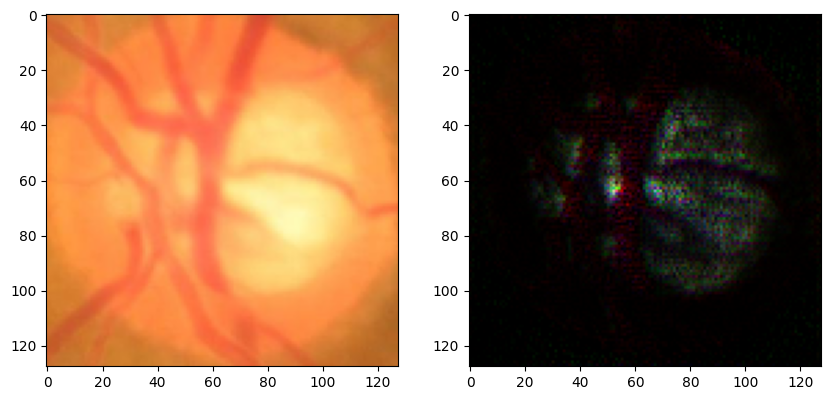

In [66]:
class GuidedBackpropagation:
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.hook_layers()

    def hook_layers(self):
        def relu_hook_function(module, grad_in, grad_out):
            if isinstance(module, torch.nn.ReLU):
                return (torch.clamp(grad_in[0], min=0.),)

        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                hook = module.register_backward_hook(relu_hook_function)
                self.hooks.append(hook)

    def unhook_layers(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()

    def guided_backward(self, image, class_idx=None, to_numpy=True):
        inputs = image.clone()
        inputs.requires_grad = True

        outputs = self.model(inputs)
        if class_idx is None:
            class_idx = torch.argmax(outputs, dim=1, keepdim=True)

        onehot = torch.zeros_like(outputs)
        onehot[0][class_idx] = 1

        outputs.backward(gradient=onehot)
        gradients = inputs.grad

        # Keep only positive gradients
        gradients = F.relu(gradients)

        # Normalize
        min_grad, max_grad = torch.min(gradients), torch.max(gradients)
        gradients = (gradients - min_grad) / (max_grad - min_grad)
        gradients = gradients.squeeze()

        if to_numpy:
            # Move channel axis to the last dimension
            gradients = gradients.permute(1, 2, 0).cpu().numpy()

        return gradients


input_image = cv.imread(r"C:\Users\ASUS\PycharmProjects\DP-GlaucomaSegmentation\data\ORIGA\Images_Cropped\049.jpg")
input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
input_image = cv.resize(input_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
input_image = torch.tensor(input_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
input_image = input_image.to(DEVICE)

guided_bp = GuidedBackpropagation(model)
guided_grads = guided_bp.guided_backward(input_image, class_idx=2)

print(guided_grads.shape, guided_grads.min(), guided_grads.max())

input_image = input_image.cpu().numpy()[0].transpose(1, 2, 0) / 255.0

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image)
ax[1].imshow(guided_grads)
plt.show()

### Grad-CAM

In [67]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.modules = dict(model.named_modules())
        if isinstance(target_layer, str):
            assert target_layer in self.modules.keys(), \
                f'Invalid target layer: {target_layer}, available layers: {self.modules.keys()}'
            self.target_layer = self.modules[target_layer]
        else:
            assert target_layer in self.modules.values(), \
                f'Invalid target layer: {target_layer}, available layers: {self.modules.keys()}'
            self.target_layer = target_layer
        self.model = model
        self.gradients = None
        self.activations = None
        self.hooks = []
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, module_input, module_output):
            self.activations = module_output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        hook = self.target_layer.register_forward_hook(forward_hook)
        self.hooks.append(hook)
        hook = self.target_layer.register_full_backward_hook(backward_hook)
        self.hooks.append(hook)

    def unregister_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()

    def __call__(self, inputs, class_idx=None, to_numpy=True):
        self.model.zero_grad()

        # Forward pass
        outputs = self.model(inputs)
        if class_idx is None:
            class_idx = torch.argmax(outputs, dim=1)

        onehot = torch.zeros(outputs.size(), dtype=torch.float32, device=inputs.device)
        onehot[0][class_idx] = 1
        outputs.backward(gradient=onehot)

        # Global average pooling to obtain the pooled gradients
        weights = torch.mean(self.gradients, dim=(0, 2, 3), keepdim=True)
        # Weight the channels by corresponding gradients
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        # Clamp negative values to zero
        cam = F.relu(cam)
        # Normalize to [0, 1]
        cam /= torch.max(cam)
        # Remove batch dimension
        cam = cam.squeeze()

        if to_numpy:
            cam = cam.detach().cpu().numpy()

        return cam

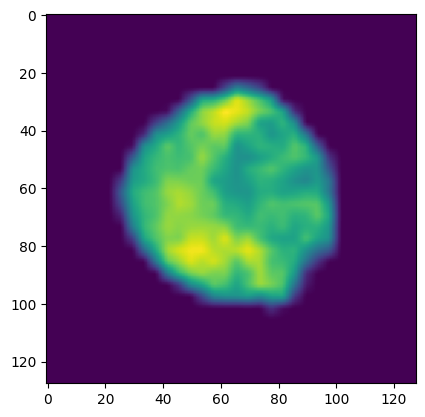

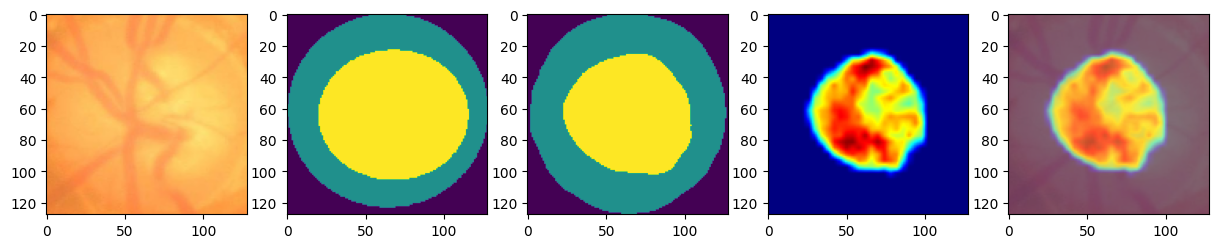

In [68]:
model_layers = dict(model.named_modules())
# print(model_layers.keys())
target_layer = model_layers['decoder.conv2.conv']

image = images[3:4]
mask = masks[3:4]

outputs = model(image)
probs = torch.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)

gradcam = GradCAM(model, target_layer)
heatmap = gradcam(image, class_idx=2)
heatmap = cv.resize(heatmap, (IMAGE_WIDTH, IMAGE_HEIGHT))
heatmap = np.uint8(255 * heatmap / np.max(heatmap))

plt.imshow(heatmap)

image = image.squeeze().detach().cpu().numpy().transpose(1, 2, 0) / 255
mask = mask.squeeze().detach().cpu().numpy()
pred = preds.squeeze().detach().cpu().numpy()

overlay = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
overlay = cv.cvtColor(overlay, cv.COLOR_BGR2RGB) / 255

alpha = 0.5
combined = alpha * overlay + (1 - alpha) * image

_, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(pred)
ax[3].imshow(overlay)
ax[4].imshow(combined)
plt.show()

gradcam.unregister_hooks()

### Guided Grad-CAM

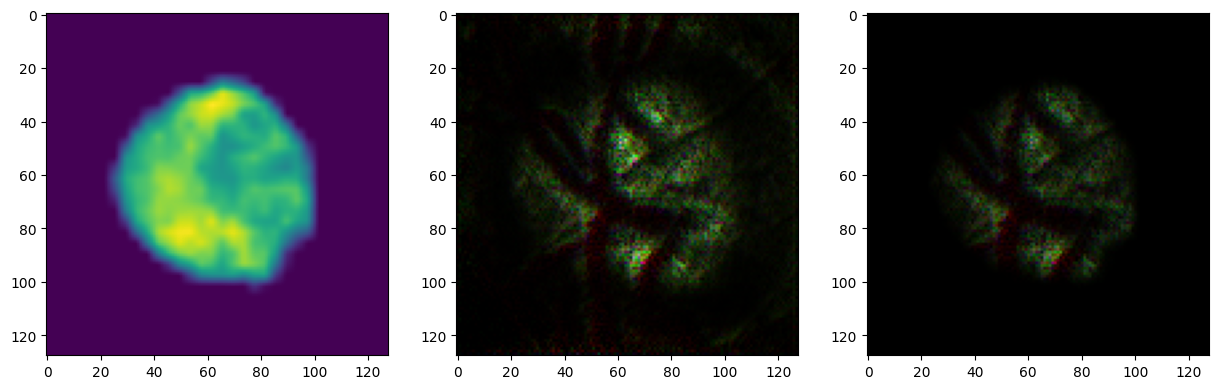

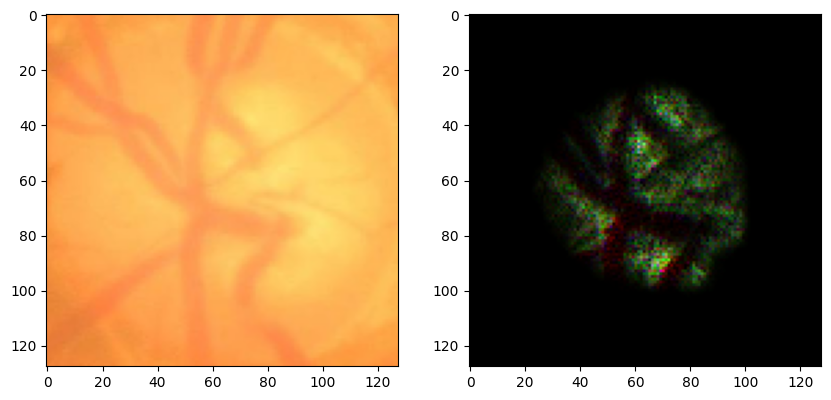

In [69]:
class GuidedGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradcam = GradCAM(model, target_layer)
        self.guided_bp = GuidedBackpropagation(model)

    def __call__(self, inputs, class_idx=None):
        cam = self.gradcam(inputs, class_idx, to_numpy=True)
        grads = self.guided_bp.guided_backward(inputs, class_idx, to_numpy=True)

        # Resize cam to guided gradients' shape
        cam = cv.resize(cam, (grads.shape[0], grads.shape[1]))
        cam = np.expand_dims(cam, axis=2)

        return grads * cam


model_layers = dict(model.named_modules())
target_layer = model_layers['decoder.conv2.conv']

image = images[3:4]
mask = masks[3:4]

outputs = model(image)
probs = torch.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)

guided_gradcam = GuidedGradCAM(model, target_layer)
guided_gradcam_mask = guided_gradcam(image, class_idx=2)
guided_gradcam_mask = cv.resize(guided_gradcam_mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
guided_gradcam_mask = np.uint8(255 * guided_gradcam_mask / np.max(guided_gradcam_mask))

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.squeeze().detach().cpu().numpy().transpose(1, 2, 0) / 255)
ax[1].imshow(guided_gradcam_mask)
plt.show()